# Facies Classification Using Various Machine Learning Methods and Result Comparison
##### [Ryan A. Mardani](https://www.linkedin.com/in/amardani/)


Facies classification is one of the most important tasks that geoscientists work on development and exploration projects. Sedimentary facies reflect particular physical, chemical, and biological condition that unit experienced during sedimentation process. To study these facies, rock samples are required. In this study, it is practiced to train various machine learning algorithms to predict facies from well log data. The dataset for this study comes from [Hugoton and Panoma Fields](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) in North America which was used in class exercise in The University of Kansas [(Dubois et. al, 2007)](https://www.sciencedirect.com/science/article/pii/S0098300406001956?via%3Dihub). It consists of log data of nine wells. We will use these log data to train supervised classifiers in order to predict discrete facies groups. All this implementation is based on [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) libraries. These are:<br> <font color=purple>
1) Support vector machines (SVM)<br>
2) Gaussian process classification (GPC)<br>
3) Random forest classifier (RFC)<br> 
4) Multi-layer Perceptron classifier(Neural Network classifier, NNC)<br>
5) K Nearest Neighbors Classifier (KNN)<br>
6) Decision tree classifier (DT)<br>
7) Logistic regression (LR)<br>

Similar to all data science approaches, we will first start with data examination. Various features of these well data will be looked at. Cross plots and well view of logs can be an appropriate approach. Then data needs to be conditioned and remove incomplete parts. To make more efficient model performance, data should be scaled to zero mean and unit variance.  Dataset will be divided into training, test and blind well data. Then, various classifiers will be employed to fit the model. After that, models will be applied to test data. In the final step. we will examine the model efficiency with a blind well which was not involved in the model building process. We mainly use data description, the plotting functions and some approaches from [Brendon Hall](https://github.com/brendonhall/facies_classification/blob/master/Facies%20Classification%20-%20SVM.ipynb), and will examine various ML approaches rather than SVM. 

## Data Understanding & Wrangling

There are plenty of learning materials we have [here](http://www.people.ku.edu/~gbohling/EECS833/) for this data set. The training data stored in CSV format contains 5 wireline log measurements, two indicators and facies label in half foot interval.
In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

In [11]:
# read data into python as dataframe 
dataset = r"C:\Users\ashuk\OneDrive\Pictures\Screenshots\facies_data.csv"
training_data = pd.read_csv(dataset)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


The Council Grove gas reservoir is located in Kansas. From this carbonate reservoir, nine wells (with 4149 examples) are avaialble. Facies are stduied from core samples in every half foot and matched with logging data in well location. Feature variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge.
The seven variables are:<br>
1. __GR__: this wireline logging tools measure gamma emission from formation. Good index for shale content.<br>
2. __ILD_log10__ : this is resistivity measurment which is applicable for identification of reservoir fluid content.<br>
3. __PE__ : photoelectric effect log can be used for lithology (mineral contet of rock) identificaiton.<br>
4. __DeltaPHI__: Phi is porosity index in petrophysics. To measure porosity, there serval methods such as neutron and density. This is differences between them.<br>
5. __PNHIND__: Average of neutron and density log.<br>
6. __NM_M__ :nonmarine-marine indicator<br>
7. __RELPOS__: relative position<br>

The nine discrete facies (classes of rocks) are: 
1. __(SS)__   Nonmarine sandstone 
2. __(CSiS)__ Nonmarine coarse siltstone
3. __(FSiS)__ Nonmarine fine siltstone 
4. __(SiSH)__ Marine siltstone and shale 
5. __(MS)__   Mudstone (limestone) 
6. __(WS)__   Wackestone (limestone)
7. __(D)__    Dolomite
8. __(PS)__   Packstone-grainstone (limestone)
9. __(BS)__   Phylloid-algal bafflestone (limestone) 

Geologically, sometimes the boundray of facies are not clear and could show some transition.The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [12]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [13]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [14]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables. Looking at the count values, most values have 4149 valid values except for PE, which has 3232. In this tutorial we will drop the feature vectors that don't have a valid PE entry.

In [15]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

Remove a single well to use as a blind test later.

In [16]:
blind = training_data[training_data['Well Name'] == 'NOLAN']
training_data = training_data[training_data['Well Name'] != 'NOLAN']

In [17]:
training_data.shape

(2817, 12)

In [18]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 6))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.40')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((5*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells `SHRIMPLIN`.  

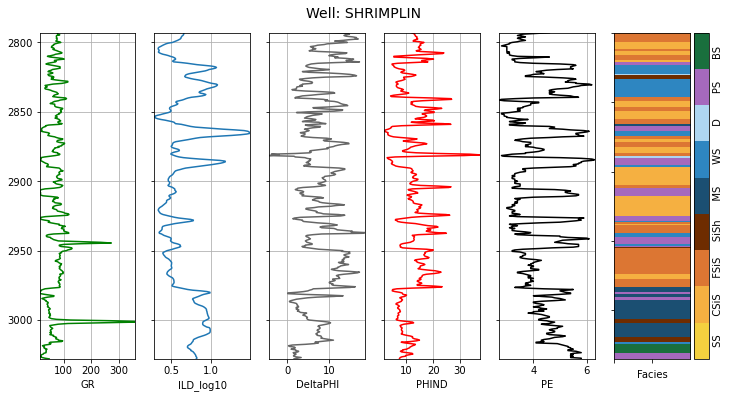

In [19]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)
#plt.savefig("SHRIMPLIN_X1", dpi=400)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histogram of the number of training examples for each facies class.

SS      255
CSiS    620
FSiS    547
SiSh    156
MS      170
WS      432
D        94
PS      382
BS      161
Name: Facies, dtype: int64

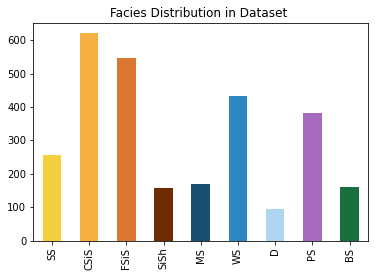

In [20]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Facies Distribution in Dataset ')
facies_counts
#plt.savefig("F_Dist.png", dpi=300)

This shows the distribution of examples by facies for the examples in the training set.  Dolomite (facies 7) has the fewest with 81 examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 9 facies.  

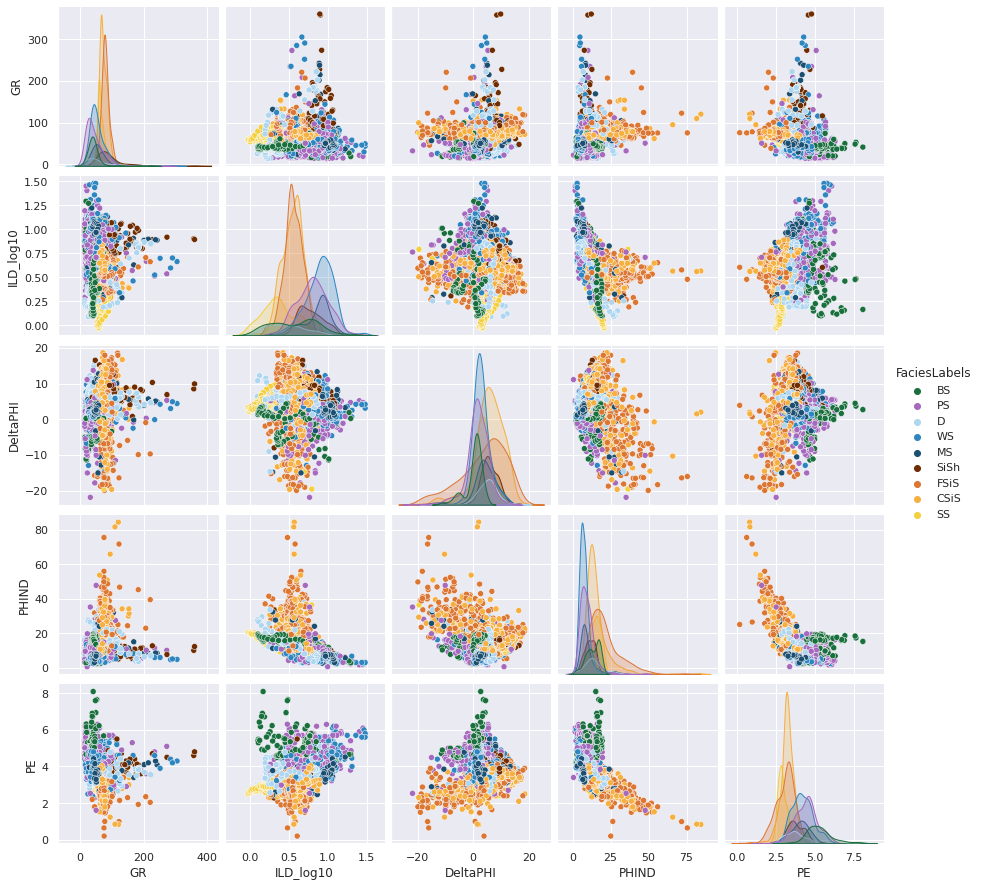

In [21]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

In [22]:
# Get correlation
training_data.corr()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Facies,1.000000,0.363199,-0.335827,0.434966,-0.221680,-0.360088,0.699465,0.860088,0.065094
Depth,0.363199,1.000000,-0.085619,0.207171,-0.087318,-0.059062,0.285313,0.313186,-0.015109
GR,-0.335827,-0.085619,1.000000,-0.147170,0.182982,0.247347,-0.299145,-0.268035,-0.186145
ILD_log10,0.434966,0.207171,-0.147170,1.000000,-0.109111,-0.520112,0.429270,0.547478,0.093388
DeltaPHI,-0.221680,-0.087318,0.182982,-0.109111,1.000000,-0.284355,0.047548,-0.151405,0.042295
PHIND,-0.360088,-0.059062,0.247347,-0.520112,-0.284355,1.000000,-0.589487,-0.487452,-0.030956
PE,0.699465,0.285313,-0.299145,0.429270,0.047548,-0.589487,1.000000,0.648681,0.017317
NM_M,0.860088,0.313186,-0.268035,0.547478,-0.151405,-0.487452,0.648681,1.000000,0.025896
RELPOS,0.065094,-0.015109,-0.186145,0.093388,0.042295,-0.030956,0.017317,0.025896,1.000000


(0.0, 9.0)

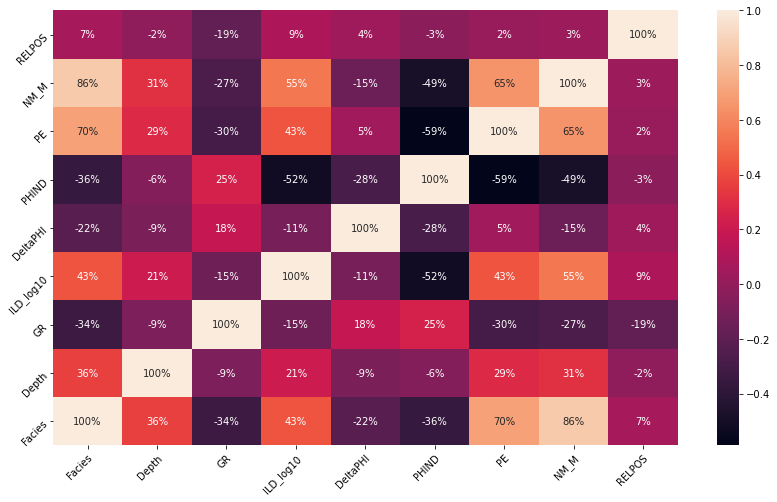

In [23]:
# Visualize data
%matplotlib inline
plt.figure(figsize=(14,8))

ax = sns.heatmap(training_data.corr(), annot=True, fmt ='.0%')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_ylim(len(training_data)-2817,9)

It seems that the best correlation of target label(facies) belongs to geological factor of NM_M with 86% agreement. PE, which is lithology loging tools shows 70%.

## Data Conditioning

We need to select feature vaiables to perform the classification. These are the five wireline values and two geologic constraining variables. The target label as Facies need to selected as well.

In [24]:
correct_facies_labels = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)

#### Preprocessing (make standard)

Almost all machine learning models work efficenctly when data is standardized for zero mean and unit variance. Using Scikit preprocessong module:

In [25]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

#### Preprocessing (Data split)

Using Scikit data split function, we may randomly split the training data into training and test sets. We select 20% of the data for the test set.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=10)

# Modeling
There are [several](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) tyes of model approaches that can be used for Facies classificaiton. Explanation the basic concept behind each methods and pros/cons of them are out of scope of this study. Almost all data science book have chapters on it. 

## Training the SVM classifier


In [27]:
from sklearn import svm
SVM_model = svm.SVC(C=10, gamma=1)

Here we used model parameters which is optimized by [Brendon Hall](https://github.com/brendonhall/facies_classification/blob/master/Facies%20Classification%20-%20SVM.ipynb).

In [28]:
SVM_model.fit(X_train,y_train)

SVC(C=10, gamma=1)

After fitting model, we can predict the result by test data

In [29]:
yhat_SVM = SVM_model.predict(X_test)

#### Model Evaluation
There are sevral metrices aviable to see how model perfrom on dataset and prediction. The basics for all types of evaluation is similar; how far/close the predicted data is from actual data. 
##### Confusion matrix 
It is a 2D array of predicted and actual target label. The entries of confusion matrix C[i][j] are equal to the number of observations predicted to have facies j, but are known to have facies i.

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics. See the file classification_utilities in Scikit-learn.

In [30]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf_SVM = confusion_matrix(y_test, yhat_SVM)
display_cm(conf_SVM, facies_labels, hide_zeros=True, display_metrics=True)

ModuleNotFoundError: No module named 'classification_utilities'

The confusion matrix has rows and columns. The rows correspond to actual facies labels and columns show model prediction results. Let's look at the first column and row. SS is shown with 42 true predictions while 6 members of SS are predicted as CSiS and 2 as FSiS. As high value as a possible outcome of the model in diagonal of the matrix, as good as model prediction perfromance. 

##### F1 Score

Precision and recall can be computed easily using the confusion matrix. Precision is the probability that given a classification result for a sample, the sample actually belongs to that class. Recall is the probability that a sample will be correctly classified for a given class.<br>
Let's look at the results and consider facies SS. In test set, if a sample was labeled SS the probability the sample was correct is 0.84 (precision). If we know a sample has facies SS, then the probability it will be correctly labeled by the classifier is 0.81 (recall). It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases. The F1 score combines both to give a single measure of relevancy of the classifier results.

These results can help guide intuition for how to improve the classifier results. For example, for a sample with facies MS or mudstone, it is only classified correctly 61% of the time (recall). Perhaps this could be improved by introducing more training samples. Sample quality could also play a role. Facies BS or bafflestone has the best F1 score and relatively few training examples. But this data was handpicked from other wells to provide training examples to identify this facies.


##### Jaccard Index
Jaccard similarity coefficient is defined as size of intersection of real (y) and predicted values (yp) divided by size of the union of those two labels.  $ J(y,y_p )=  (|y∩y_p |)/(|y∪y_p |) $. <br> 
For example, for a set of size 10 samples with 8 correct prediction, this index will be 0.66.

In [22]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

jSVM = jaccard_similarity_score(y_test, yhat_SVM)
f1SVM = f1_score(y_test, yhat_SVM, average='weighted')
print("SVM Jaccard index: %.3f" % jSVM )
print("SVM F1-score: %.3f" % f1SVM  )

SVM Jaccard index: 0.745
SVM F1-score: 0.746


C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


## Training the GaussianProcessClassifier classifier

In [23]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

GPC_model = GaussianProcessClassifier().fit(X_train, y_train)

yhat_GPC = GPC_model.predict(X_test)
jGPC = jaccard_similarity_score(y_test, yhat_GPC)
f1GPC = f1_score(y_test, yhat_GPC, average='weighted')
print("GPC Jaccard index: %.3f" % jGPC)
print("GPC F1-score: %.3f" % jGPC )

conf_GPC = confusion_matrix(y_test, yhat_GPC)
display_cm(conf_GPC, facies_labels, hide_zeros=True, display_metrics=True)

GPC Jaccard index: 0.663
GPC F1-score: 0.663
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    34    16     2                                        52
     CSiS     8    75    30                 1                     114
     FSiS     1    28    72     1     1     1           1         105
     SiSh                      25          10           2          37
       MS                            10    12     1     5          28
       WS                 1     3     7    71          16     2   100
        D           1                       1    20     5     2    29
       PS                       1     2    20     2    46     5    76
       BS                                   1           1    21    23

Precision  0.79  0.62  0.69  0.83  0.50  0.61  0.87  0.61  0.70  0.67
   Recall  0.65  0.66  0.69  0.68  0.36  0.71  0.69  0.61  0.91  0.66
       F1  0.72  0.64  0.69  0.75  0.42  0.65  0.77  0.61  0.79  0.66


C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


## Training the RandomForestClassifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

RFC_model = RandomForestClassifier(max_depth=12, n_estimators=20, max_features=6).fit(X_train, y_train)


yhat_RFC = RFC_model.predict(X_test)

jRFC  = jaccard_similarity_score(y_test, yhat_RFC)
f1RFC = f1_score(y_test, yhat_RFC, average='weighted')

print("RFC Jaccard index: %.3f" % jRFC )
print("RFC F1-score: %.3f" % f1RFC)

conf_RFC = confusion_matrix(y_test, yhat_RFC)
display_cm(conf_RFC, facies_labels, hide_zeros=True, display_metrics=True)

RFC Jaccard index: 0.693
RFC F1-score: 0.695
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    35    15     2                                        52
     CSiS     4    89    20                 1                     114
     FSiS     1    29    70           1     2           2         105
     SiSh                      23     2     9           3          37
       MS                       2    12     7           7          28
       WS                 1     2     7    75          13     2   100
        D           1                 3     1    19     4     1    29
       PS                             4    24     1    47          76
       BS                                   1           1    21    23

Precision  0.88  0.66  0.75  0.85  0.41  0.62  0.95  0.61  0.88  0.71
   Recall  0.67  0.78  0.67  0.62  0.43  0.75  0.66  0.62  0.91  0.69
       F1  0.76  0.72  0.71  0.72  0.42  0.68  0.78  0.61  0.89  0.69


C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


## Training the Neural Network Classifier

In [25]:
from sklearn.neural_network import MLPClassifier


NNC_model = MLPClassifier(alpha=0.001, max_iter=1000, learning_rate_init=0.001, 
                          solver='adam', batch_size=10, hidden_layer_sizes=200 ).fit(X_train, y_train)

yhat_NNC = NNC_model.predict(X_test)
jNNC  =  jaccard_similarity_score(y_test, yhat_NNC)
f1NNC =  f1_score(y_test, yhat_NNC, average='weighted')

print("NNC Jaccard index: %.3f" %jNNC)
print("NNC F1-score: %.3f" %f1NNC )

conf_NNC = confusion_matrix(y_test, yhat_NNC)
display_cm(conf_NNC, facies_labels, hide_zeros=True, display_metrics=True)

NNC Jaccard index: 0.723
NNC F1-score: 0.724
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    37    13     2                                        52
     CSiS     4    85    24                             1         114
     FSiS     2    20    80     1           2                     105
     SiSh                      27     1     6           3          37
       MS                 1     2    13     7           5          28
       WS                 3     1     4    71          20     1   100
        D           1                 1          21     4     2    29
       PS                             6    12     1    53     4    76
       BS                                   2                21    23

Precision  0.86  0.71  0.73  0.87  0.52  0.71  0.95  0.62  0.75  0.73
   Recall  0.71  0.75  0.76  0.73  0.46  0.71  0.72  0.70  0.91  0.72
       F1  0.78  0.73  0.74  0.79  0.49  0.71  0.82  0.65  0.82  0.72


C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


## Training the K Neighbor Classifier

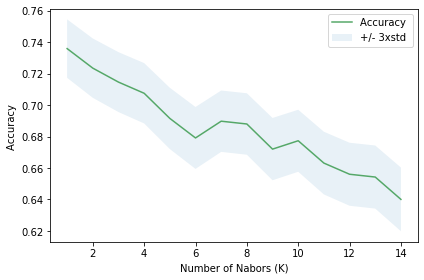

KNN Jaccard index: 0.716
KNN F1-score: 0.717
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    40    10     2                                        52
     CSiS     5    78    30     1                                 114
     FSiS     2    21    77     1     1     1           2         105
     SiSh                      27     1     7           2          37
       MS                       4    15     5           4          28
       WS                 1     3     5    73          15     3   100
        D           1                 1          24     2     1    29
       PS                            10    14     1    48     3    76
       BS                                               1    22    23

Precision  0.85  0.71  0.70  0.75  0.45  0.73  0.96  0.65  0.76  0.72
   Recall  0.77  0.68  0.73  0.73  0.54  0.73  0.83  0.63  0.96  0.72
       F1  0.81  0.70  0.72  0.74  0.49  0.73  0.89  0.64  0.85  0.72


C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [26]:

from sklearn.neighbors import KNeighborsClassifier
# to chose the best k value we may run in range of valus 
Ks =15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusMtx = [];

for n in range(1,Ks):
    KNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = KNN_model.predict(X_test)
    
    mean_acc[n-1]= np.mean(yhat==y_test);
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

k = 5    #it seems 5 is good enough
KNN_model = KNeighborsClassifier(n_neighbors=k ,leaf_size=50, p=1,  weights='distance' ).fit(X_train, y_train)
KNN_model
#plot
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()


yhat_KNN = KNN_model.predict(X_test)

jKNN  = jaccard_similarity_score(y_test, yhat_KNN)
f1KNN = f1_score(y_test, yhat_KNN, average='weighted')
print("KNN Jaccard index: %.3f" % jKNN )
print("KNN F1-score: %.3f" % f1KNN  )

conf_KNN = confusion_matrix(y_test, yhat_KNN)
display_cm(conf_KNN, facies_labels, hide_zeros=True, display_metrics=True)

## Training the Decision Tree classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 25, min_samples_split=3 )
DT_model.fit(X_train,y_train)
DT_model

yhat_DT = DT_model.predict(X_test)

jDT  = jaccard_similarity_score(y_test, yhat_DT)
f1DT = f1_score(y_test, yhat_DT, average='weighted')
print("DT Jaccard index: %.3f" % jDT )
print("DT F1-score: %.3f" % f1DT )

conf_DT = confusion_matrix(y_test, yhat_DT)
display_cm(conf_DT, facies_labels, hide_zeros=True, display_metrics=True)

DT Jaccard index: 0.598
DT F1-score: 0.600
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    39    12     1                                        52
     CSiS     7    73    32     1     1                           114
     FSiS     1    33    65     1     1     2           2         105
     SiSh                      19     3    10           4     1    37
       MS           1           1    13     8     1     4          28
       WS                 2     4    11    55          23     5   100
        D           1           2     4     2    14     4     2    29
       PS                       1     6    25     2    40     2    76
       BS                                   1           3    19    23

Precision  0.83  0.61  0.65  0.66  0.33  0.53  0.82  0.50  0.66  0.61
   Recall  0.75  0.64  0.62  0.51  0.46  0.55  0.48  0.53  0.83  0.60
       F1  0.79  0.62  0.63  0.58  0.39  0.54  0.61  0.51  0.73  0.60


C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


## Training the Logistic Regression classifier

In [28]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=1).fit(X_train,y_train)
LR_model

yhat_LR = LR_model.predict(X_test)

jLR  = jaccard_similarity_score(y_test, yhat_LR)
f1LR = f1_score(y_test, yhat_LR, average='weighted')
print("LR Jaccard index: %.3f" % jLR )
print("LR F1-score: %.3f" % f1LR )

conf_LR = confusion_matrix(y_test, yhat_LR)
display_cm(conf_LR, facies_labels, hide_zeros=True, display_metrics=True)

LR Jaccard index: 0.603
LR F1-score: 0.589
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    37    15                                              52
     CSiS     7    82    23                 1           1         114
     FSiS     2    41    55     2     1     2           2         105
     SiSh                      16          20                 1    37
       MS                       2     1    19     1     5          28
       WS                 1     3          76     2    15     3   100
        D                 1     3           3    15     6     1    29
       PS                       1     3    22     2    40     8    76
       BS                                   1           4    18    23

Precision  0.80  0.59  0.69  0.59  0.20  0.53  0.75  0.55  0.58  0.60
   Recall  0.71  0.72  0.52  0.43  0.04  0.76  0.52  0.53  0.78  0.60
       F1  0.76  0.65  0.59  0.50  0.06  0.62  0.61  0.54  0.67  0.59


C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


#### Table E1, Create dataframe of model evaluation 

In [29]:
# create dictionary with calculated errors as variables
data_frame1 ={'Model type': ['SVM', 'GPC', 'RFC', 'NNC', 'KNN', 'DT', 'LR'],
       'Jaccard index': [jSVM, jGPC, jRFC, jNNC, jKNN, jDT, jLR],
       'F1-Score': [f1SVM, f1GPC, f1RFC, f1NNC, f1KNN, f1DT, f1LR]
            }
df1 = pd.DataFrame(data_frame1, columns = ['Model type','Jaccard index','F1-Score' ] )
df1.round(2)

,Model type,Jaccard index,F1-Score
0,SVM,0.74,0.75
1,GPC,0.66,0.66
2,RFC,0.69,0.69
3,NNC,0.72,0.72
4,KNN,0.72,0.72
5,DT,0.60,0.60
6,LR,0.60,0.59


## Applying the classification model to the blind data

As we selected one well out of the training data from traning and model fitting process, it can be good estimate to see how models work.

Let's store target labet from blind well in:

In [30]:
y_blind = blind['Facies'].values

Calling the same features for prediction, by dropping some of the columns and making a new dataframe:

In [31]:
blind_features = blind.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)

Now we can transform this with the scaler we made before:

In [32]:
X_blind = scaler.transform(blind_features)

Now it's a simple matter of making a prediction and storing it back in the dataframe:

#### Predicting facies for blind well by all models

In [33]:
#SVM
yhat_blind_SVM = SVM_model.predict(X_blind)
blind['SVM_Pred'] = yhat_blind_SVM

#GPC
yhat_blind_GPC = GPC_model.predict(X_blind)
blind['GPC_Pred'] = yhat_blind_GPC

#RFC
yhat_blind_RFC = RFC_model.predict(X_blind)
blind['RFC_Pred'] = yhat_blind_RFC

#NNC
yhat_blind_NNC = NNC_model.predict(X_blind)
blind['NNC_Pred'] = yhat_blind_NNC

#KNN
yhat_blind_KNN = KNN_model.predict(X_blind)
blind['KNN_Pred'] = yhat_blind_KNN

#DT
yhat_blind_DT = DT_model.predict(X_blind)
blind['DT_Pred'] = yhat_blind_DT

#LR
yhat_blind_LR = LR_model.predict(X_blind)
blind['LR_Pred'] = yhat_blind_LR



#### Let's see how prediction works on blind data:

In [34]:
#SVM
jSVM_b =  jaccard_similarity_score(y_blind, yhat_blind_SVM)
f1SVM_b = f1_score(y_blind, yhat_blind_SVM, average='weighted')
# print("SVM Jaccard index for blind well prediction: %.3f" %jSVM_b)
# print("SVM F1-score for blind well prediction: %.3f" %f1SVM_b )

#GPC
jGPC_b =jaccard_similarity_score(y_blind, yhat_blind_GPC)
f1GPC_b =f1_score(y_blind, yhat_blind_GPC, average='weighted')
# print("GPC Jaccard index for blind well prediction: %.3f" %jGPC_b )
# print("GPC F1-score for blind well prediction: %.3f" % f1GPC_b)

#RFC
jRFC_b =jaccard_similarity_score(y_blind, yhat_blind_RFC)
f1RFC_b=f1_score(y_blind, yhat_blind_RFC, average='weighted')
# print("RFC Jaccard index for blind well prediction: %.3f" % jRFC_b)
# print("RFC F1-score for blind well prediction: %.3f" % f1RFC_b)

#NNC
jNNC_b  =jaccard_similarity_score(y_blind, yhat_blind_NNC)
f1NNC_b =f1_score(y_blind, yhat_blind_NNC, average='weighted')
# print("NNC Jaccard index for blind well prediction: %.3f" %jNNC_b )
# print("NNC F1-score for blind well prediction: %.3f" %f1NNC_b )

#KNN
jKNN_b = jaccard_similarity_score(y_blind, yhat_blind_KNN)
f1KNN_b = f1_score(y_blind, yhat_blind_KNN, average='weighted')
# print("KNN Jaccard index for blind well prediction: %.3f" % jKNN_b)
# print("KNN F1-score for blind well prediction: %.3f" %f1KNN_b  )

#DT
jDT_b = jaccard_similarity_score(y_blind, yhat_blind_DT)
f1DT_b =f1_score(y_blind, yhat_blind_DT, average='weighted')
# print("DT Jaccard index for blind well prediction: %.3f" % jDT_b)
# print("DT F1-score for blind well prediction: %.3f" % f1DT_b )

#LR
jLR_b  = jaccard_similarity_score(y_blind, yhat_blind_LR)
f1LR_b = f1_score(y_blind, yhat_blind_LR, average='weighted')
# print("LR Jaccard index for blind well prediction: %.3f" % jLR_b)
# print("LR F1-score for blind well prediction: %.3f" %f1LR_b )


C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Alireza\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
C:\Users\Alireza\Anaconda3\lib\s

#### Table E2, Create dataframe of model evaluation for blind well performance

In [35]:
data_frame2 ={'Model type': ['SVM', 'GPC', 'RFC', 'NNC', 'KNN', 'DT', 'LR'],
       'Jaccard index': [jSVM_b, jGPC_b, jRFC_b, jNNC_b, jKNN_b, jDT_b, jLR_b],
       'F1-Score': [f1SVM_b, f1GPC_b, f1RFC_b, f1NNC_b, f1KNN_b, f1DT_b, f1LR_b]
            }
df2 = pd.DataFrame(data_frame2, columns = ['Model type','Jaccard index','F1-Score' ] )
df2.round(2)

,Model type,Jaccard index,F1-Score
0,SVM,0.46,0.49
1,GPC,0.47,0.50
2,RFC,0.49,0.52
3,NNC,0.56,0.58
4,KNN,0.46,0.51
5,DT,0.41,0.45
6,LR,0.48,0.50


Now we can plot one of the model's prediction performance with blind well data.

In [36]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 6))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((5*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

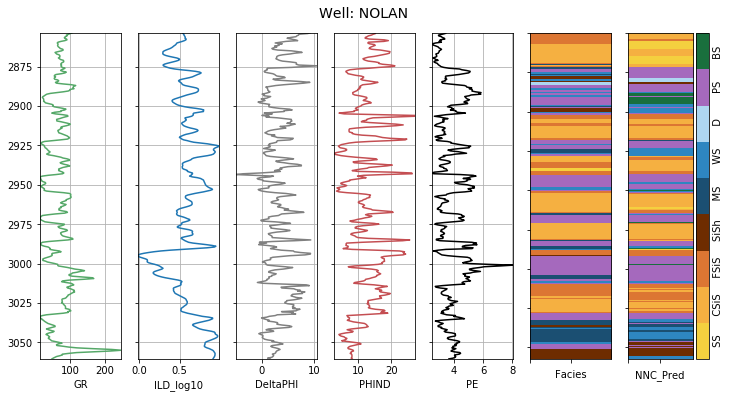

In [37]:
#let's plot KNN result
compare_facies_plot(blind, 'NNC_Pred', facies_colors)
#plt.savefig("KNN.png", dpi=400)

#### Create a section to compare various model performance in facies prediction 

In [38]:
def compare_all_facies(logs, Pred1, Pred2, Pred3, Pred4, Pred5, Pred6, Pred7, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[Pred1].values,1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs[Pred2].values,1), 100, 1)
    cluster4 = np.repeat(np.expand_dims(logs[Pred3].values,1), 100, 1)
    cluster5 = np.repeat(np.expand_dims(logs[Pred4].values,1), 100, 1)
    cluster6 = np.repeat(np.expand_dims(logs[Pred5].values,1), 100, 1)
    cluster7 = np.repeat(np.expand_dims(logs[Pred6].values,1), 100, 1)
    cluster8 = np.repeat(np.expand_dims(logs[Pred7].values,1), 100, 1)

   
    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(12, 6))

    im1 = ax[0].imshow(cluster1, interpolation='none', aspect='auto',
                       cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[1].imshow(cluster2, interpolation='none', aspect='auto',
                       cmap=cmap_facies,vmin=1,vmax=9)
    im3 = ax[2].imshow(cluster3, interpolation='none', aspect='auto',
                       cmap=cmap_facies,vmin=1,vmax=9)
    im4 = ax[3].imshow(cluster4, interpolation='none', aspect='auto',
                       cmap=cmap_facies,vmin=1,vmax=9)
    im5 = ax[4].imshow(cluster5, interpolation='none', aspect='auto',
                       cmap=cmap_facies,vmin=1,vmax=9)
    im6 = ax[5].imshow(cluster6, interpolation='none', aspect='auto',
                       cmap=cmap_facies,vmin=1,vmax=9)
    im7 = ax[6].imshow(cluster7, interpolation='none', aspect='auto',
                       cmap=cmap_facies,vmin=1,vmax=9)
    im8 = ax[7].imshow(cluster8, interpolation='none', aspect='auto',
                       cmap=cmap_facies,vmin=1,vmax=9)
       
    
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cbar=plt.colorbar(im8, cax=cax)
    cbar.set_label((5*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-8):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=2)
    
    ax[0].set_xlabel('Facies'); ax[1].set_xlabel(Pred1); ax[2].set_xlabel(Pred2)
    ax[3].set_xlabel(Pred3); ax[4].set_xlabel(Pred4); ax[5].set_xlabel(Pred5)
    ax[6].set_xlabel(Pred6); ax[7].set_xlabel(Pred7)
    
    #ax[0].set_yticklabels([]) ;
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]) 
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[7].set_yticklabels([])
    
    ax[0].set_xticklabels([]); ax[1].set_xticklabels([]); ax[2].set_xticklabels([])
    ax[3].set_xticklabels([]); ax[4].set_xticklabels([]); ax[5].set_xticklabels([])
    ax[6].set_xticklabels([]); ax[7].set_xticklabels([])

    f.suptitle('Various model predictions in well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

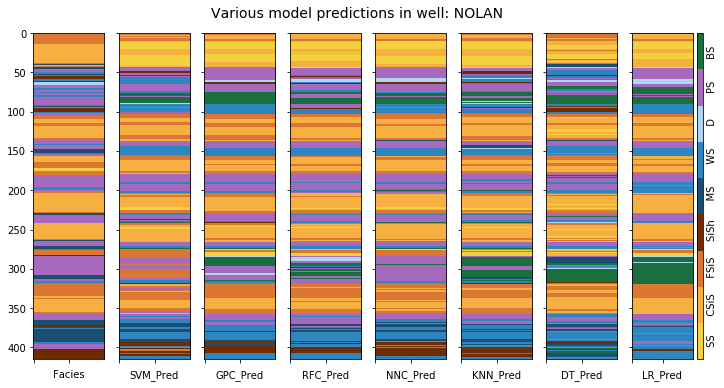

In [39]:
compare_all_facies(blind,'SVM_Pred','GPC_Pred','RFC_Pred', 'NNC_Pred', 'KNN_Pred','DT_Pred', 'LR_Pred', facies_colors)
plt.savefig("Compo.png", dpi=400)

## Conclustion:

1. SVM, NNC, and KNN show better performance in test data(table E1).<br>
2. When it comes to examining models with new data(blind well) all model performance drops (table E2). <br>
3. This can be attributed to data shortage. If we look at carefully the last cross-section showing various model outputs compared with real facies distribution, SS,  CSiS, and FSiS correlate appropriately. PS has the next better agreement with real data. BS, and D show the weakest correlation with real facies distribution. <br>
4. The trend mentioned above (3), is in agreement with data sample frequency which showed at the first step of data wrangling in the bar chart. Facies are predicted better if they have enough samples in the training data set.<br> 
5. To improve the results we can work on two important aspects: 1.introduce more data sample to models, 2. optimize model parametrers in detail.

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)